In [1]:
import numpy as np
from tqdm import tqdm
from skimage import io, transform
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
from torch.autograd import Variable
import torch.nn as NN
from torch.optim import Adam, SGD
import time
import glob
import xmltodict
import cv2

In [2]:
data_images_path     = '../VOCdevkit/VOC2012/JPEGImages'
data_annotation_path = '../VOCdevkit/VOC2012/Annotations'
trained_model_path = './trained_model/'
image_sizes = [320,352,384,416,448,480,512,544,570,608]
image_height = image_sizes[0]
image_width = image_sizes[0]
image_depth  = 3

In [3]:
#Get the image and annotation file paths
list_images      = sorted([x for x in glob.glob(data_images_path + '/**')])     #length : 17125
list_annotations = sorted([x for x in glob.glob(data_annotation_path + '/**')]) #length : 17125
total_images = len(list_images)

In [4]:
def get_classes(xml_files=list_annotations):
    '''
    Output: All the distinct classes for this dataset.
    
    '''
    classes = []
    
    for file in xml_files: 

        f = open(file)
        doc = xmltodict.parse(f.read()) #parse the xml file to python dict.

        #Images in the dataset might contain either 1 object or more than 1 object. For images with 1 object, the annotation for the object
        #in the xml file will be located in 'annotation' -> 'object' -> 'name'. For images with more than 1 object, the annotations for the objects
        #will be nested in 'annotation' -> 'object' thus requiring a loop to iterate through them. (Pascal VOC format)

        try: 
            #try iterating through the tag. (For images with more than 1 obj.)
            for obj in doc['annotation']['object']:
                classes.append(obj['name'].lower()) #append the lowercased string.

        except TypeError as e: #iterating through non-nested tags would throw a TypeError.
            classes.append(doc['annotation']['object']['name'].lower()) #append the lowercased string.

        f.close()

    classes = list(set(classes)) #remove duplicates.
    classes.sort()

    #returns a list containing the names of classes after being sorted.
    return classes

In [5]:
classes = get_classes()
num_of_class = len(classes)
excluded_classes = []

In [6]:
def get_classes(xml_files=list_annotations):
    '''
    Output: All the distinct classes for this dataset.
    
    '''
    classes = []
    
    for file in xml_files: 

        f = open(file)
        doc = xmltodict.parse(f.read()) #parse the xml file to python dict.

        #Images in the dataset might contain either 1 object or more than 1 object. For images with 1 object, the annotation for the object
        #in the xml file will be located in 'annotation' -> 'object' -> 'name'. For images with more than 1 object, the annotations for the objects
        #will be nested in 'annotation' -> 'object' thus requiring a loop to iterate through them. (Pascal VOC format)

        try: 
            #try iterating through the tag. (For images with more than 1 obj.)
            for obj in doc['annotation']['object']:
                classes.append(obj['name'].lower()) #append the lowercased string.

        except TypeError as e: #iterating through non-nested tags would throw a TypeError.
            classes.append(doc['annotation']['object']['name'].lower()) #append the lowercased string.

        f.close()

    classes = list(set(classes)) #remove duplicates.
    classes.sort()

    #returns a list containing the names of classes after being sorted.
    return classes

In [7]:
def get_labels_from_xml(xml_file_path, num_of_class = num_of_class):
    '''
    Input : A SINGLE xml file and the total number of classes in the dataset. 
    Output: Labels in numpy array format (Object classes their corresponding bounding box coordinates).

    Desc : This function parses a single xml file and outputs the objects classes and their corresponding bounding box coordinates
           [top-left-x, top-left-y, btm-right-x, btm-right-y] on the resized image.

    '''

    f = open(xml_file_path)
    doc = xmltodict.parse(f.read()) #parse the xml file to python dict.

    #get the original image height and width. Images have different height and width from each other.
    ori_img_height = float(doc['annotation']['size']['height'])
    ori_img_width  = float(doc['annotation']['size']['width'])


    class_label = [] #init for keeping track objects' labels.
    bbox_label  = [] #init for keeping track of objects' bounding box (bb).


    #Images in the dataset might contain either 1 object or more than 1 object. For images with 1 object, the annotation for the object
    #in the xml file will be located in 'annotation' -> 'object' -> 'name'. For images with more than 1 object, the annotations for the objects
    #will be nested in 'annotation' -> 'object' thus requiring a loop to iterate through them. (Pascal VOC format)
    try:
        #Try iterating through the tag (For images with more than 1 obj).
        for each_obj in doc['annotation']['object']:
            
            obj_class = each_obj['name'].lower() #get the label for the object and lowercase the string.
            
            if obj_class in excluded_classes:
                continue

            #Pascal VOC's format to denote bounding boxes are to denote the top left part of the box and the bottom right of the box.
            #the coordinates are in terms of x and y axis for both part of the box.
            x_min = float(each_obj['bndbox']['xmin']) #top left x-axis coordinate.
            x_max = float(each_obj['bndbox']['xmax']) #bottom right x-axis coordinate.
            y_min = float(each_obj['bndbox']['ymin']) #top left y-axis coordinate.
            y_max = float(each_obj['bndbox']['ymax']) #bottom right y-axis coordinate.

        ##################################################################################
        #We want to make sure the coordinates are resized according to the resized image.#
        ##################################################################################

            #All the images will be resized to a fixed size in order to be fixed-size inputs to the neural network model.
            #Therefore, we need to resize the coordinates as well since the coordinates above is based on the original size of the images.

            #In order to find the resized coordinates, we must multiply the ratio of the resized image compared to its original to the coordinates.
            x_min = float((image_width/ori_img_width)*x_min)
            y_min = float((image_height/ori_img_height)*y_min)
            x_max = float((image_width/ori_img_width)*x_max)
            y_max = float((image_height/ori_img_height)*y_max)
            

            generated_box_info = [x_min, y_min, x_max, y_max]


            index = classes.index(obj_class) #get the index of the object's class.

            #append each object's class label and the bounding box label (converted to Faster R-CNN format) into the list initialized earlier.
            class_label.append(index)
            bbox_label.append(np.asarray(generated_box_info, dtype='float32'))

    except TypeError as e : #happens when the iteration through the tag fails due to only 1 object being in the image.

        #SAME PROCEDURE AS ABOVE !  

        #Getting these information from the XML file differs compared to above,
        obj_class = doc['annotation']['object']['name']
        
        if not obj_class in excluded_classes:
                        
            x_min = float(doc['annotation']['object']['bndbox']['xmin']) 
            x_max = float(doc['annotation']['object']['bndbox']['xmax']) 
            y_min = float(doc['annotation']['object']['bndbox']['ymin']) 
            y_max = float(doc['annotation']['object']['bndbox']['ymax']) 

            x_min = float((image_width/ori_img_width)*x_min)
            y_min = float((image_height/ori_img_height)*y_min)
            x_max = float((image_width/ori_img_width)*x_max)
            y_max = float((image_height/ori_img_height)*y_max)

            generated_box_info = [x_min, y_min, x_max, y_max]

            #Get the index of the class
            index = classes.index(obj_class) 

            class_label.append(index)
            bbox_label.append(np.asarray(generated_box_info, dtype='float32'))


    return class_label, np.asarray(bbox_label)

In [8]:
class K_Means:
    
    
    def __init__(self, k, boxes):
        
        self.k = k
        self.boxes = boxes
        self.rows = self.boxes.shape[0]
        self.distances = np.empty((self.rows, self.k))
        self.last_centroids = np.zeros((self.rows,))
        
        self.boxes = self.process_boxes(self.boxes)
        self.centroids = []
        for i in range(self.k):
            self.centroids.append(self.boxes[i,:])
        
        self.centroids = np.asarray(self.centroids, dtype=np.float32)
        
    def process_boxes(self, boxes):
        
        new_boxes = boxes.copy()
        for row in range(self.rows):
#             width = np.abs(new_boxes[row][2] - new_boxes[row][0])
#             height = np.abs(new_boxes[row][3] - new_boxes[row][1])
            
#             new_boxes[row][0] = new_boxes[row][0] / width
#             new_boxes[row][1] = new_boxes[row][1] / height
#             new_boxes[row][2] = new_boxes[row][2] / width
#             new_boxes[row][3] = new_boxes[row][3] / height
            
            new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
            new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
        
        return np.delete(new_boxes, [0,1], axis=1)
    
    def iou(self, box, centroids):
        
        x = np.minimum(centroids[:, 0], box[0])
        y = np.minimum(centroids[:, 1], box[1])
        
        if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
            raise ValueError("The given box has no area!")
        
        intersection_area = x * y
        box_area = box[0] * box[1]
        centroid_area = centroids[:, 0] * centroids[:, 1]
        
        IoUs = intersection_area / (box_area + centroid_area - intersection_area)
        
        return IoUs
    
    def __call__(self):
        
        
        while True:
            
            for row in range(self.rows):
                self.distances[row] = 1 - self.iou(self.boxes[row], self.centroids)
            
            nearest_centroids = np.argmin(self.distances, axis=1)
            
            if (self.last_centroids == nearest_centroids).all():
                break
            
            for cluster in range(self.k):
                self.centroids[cluster] = np.mean(self.boxes[nearest_centroids == cluster], axis=0)
                
            self.last_centroids = nearest_centroids
        
        return self.centroids

In [9]:
gt_boxes_array = []
for i in range(total_images):
    
    true_labels, gt_boxes = get_labels_from_xml(xml_file_path=list_annotations[i])
    if len(gt_boxes) == 1:
        
        gt_boxes_array.append(np.asarray(gt_boxes[0], dtype=np.float32))
    else:
        for i in range(len(gt_boxes)):
            gt_boxes_array.append(np.asarray(gt_boxes[i], dtype=np.float32))

len(gt_boxes_array)

40138

In [10]:
gt_boxes_array = np.asarray(gt_boxes_array)

In [11]:
kmeans = K_Means(k=5, boxes=gt_boxes_array)

In [12]:
n = kmeans()

In [13]:
n = n

In [14]:
img = np.zeros((320,320,3))
cv2.rectangle(img, (4,4), (int(n[0][0])+4,int(n[0][1])+4), (255,255,255), 2)
cv2.rectangle(img, (4,4), (int(n[1][0])+4,int(n[1][1])+4),  (255,255,0), 2)
cv2.rectangle(img, (4,4), (int(n[2][0])+4,int(n[2][1])+4),  (0,0,255), 2)
cv2.rectangle(img, (4,4), (int(n[3][0])+4,int(n[3][1])+4),  (255,0,0), 2)
cv2.rectangle(img, (4,4), (int(n[4][0])+4,int(n[4][1])+4),  (100,0,50), 2)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

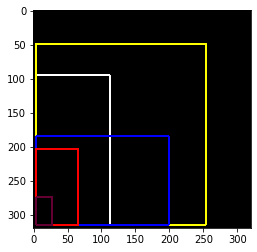

In [15]:
plt.imshow(cv2.flip(img.astype(np.uint8),0))
plt.show()

In [16]:
a = np.random.randint(100,size=(10,2))
b = np.asarray([24.5])
print(a,b)

[[38 75]
 [18 24]
 [49 92]
 [29 74]
 [76 36]
 [59 27]
 [67 28]
 [13 24]
 [ 3 27]
 [47 80]] [24.5]


In [17]:
np.minimum(a[:,1], b)

array([24.5, 24. , 24.5, 24.5, 24.5, 24.5, 24.5, 24. , 24.5, 24.5])